               Model       MSE        R²
0      Random Forest  2.311379  0.520856
1  Gradient Boosting  2.230421  0.537067
2            XGBoost  2.319859  0.516712
3  Linear Regression  3.084072  0.360815
Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Final R²: 0.8653454261617192


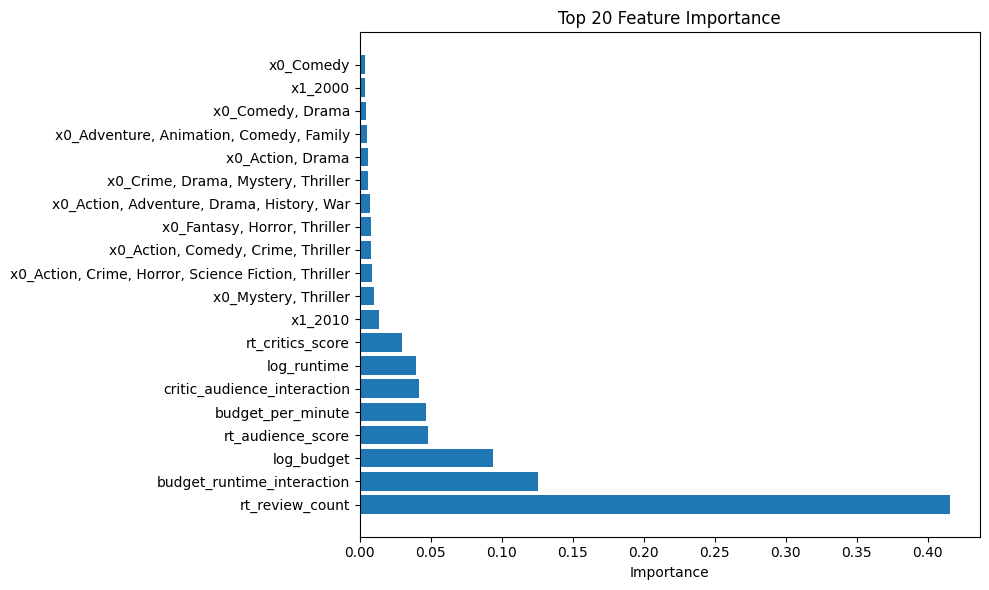

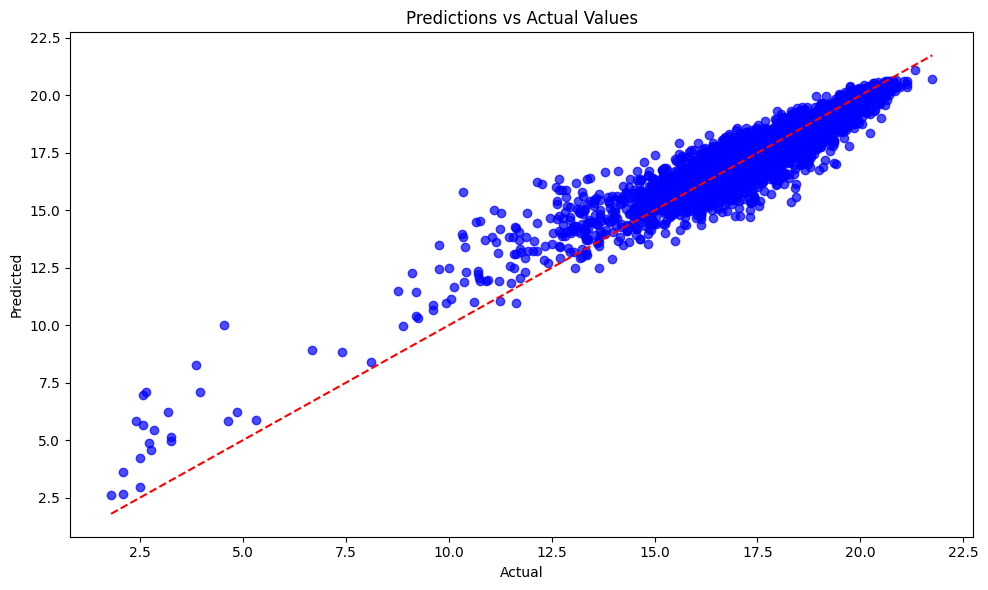

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from collections import Counter
import ast
from sklearn.model_selection import train_test_split


df_movies = pd.read_csv(r"data/rotten_tomatoes_5000_movies.csv")
df_credit = pd.read_csv(r"data/rotten_tomatoes_5000_credits.csv")

# Merge df_movies and df_credit on 'rt_movie_id'
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')

# Remove rows where 'rt_box_office' is 0
df = df[df['rt_box_office'] != 0]

# **1. Feature Engineering**

# Parse genres, actors, and directors safely
def parse_genres(genres_str):
    try:
        genres = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres]
    except:
        return []

def parse_actors(actors_str):
    try:
        actors = ast.literal_eval(actors_str)
        return [actor['name'] for actor in actors]
    except:
        return []

def parse_directors(staff_str):
    try:
        staff = ast.literal_eval(staff_str)
        return [staff_member['name'] for staff_member in staff if staff_member['job'] == 'Director']
    except:
        return []

# Merge datasets
df = pd.merge(df_movies, df_credit, on='rt_movie_id', how='left')
df = df[df['rt_box_office'] != 0]  # Remove rows with zero box office

# Parse columns
df['parsed_genres'] = df['rt_genres'].apply(parse_genres)
df['parsed_actors'] = df['rt_actors'].apply(parse_actors)
df['parsed_directors'] = df['rt_staff'].apply(parse_directors)

# Create genre combinations as a single feature
df['genre_combination'] = df['parsed_genres'].apply(lambda x: ', '.join(sorted(x)) if x else '')

# Famous actors and directors
all_actors = [actor for actors_list in df['parsed_actors'] for actor in actors_list]
actor_counts = Counter(all_actors)
top_actors = [actor for actor, _ in actor_counts.most_common(15)]

all_directors = [director for directors_list in df['parsed_directors'] for director in directors_list]
director_counts = Counter(all_directors)
top_directors = [director for director, _ in director_counts.most_common(8)]

df['num_famous_actors'] = df['parsed_actors'].apply(lambda x: sum(actor in top_actors for actor in x))
df['num_famous_directors'] = df['parsed_directors'].apply(lambda x: sum(director in top_directors for director in x))

# Create derived features
df['log_budget'] = np.log1p(df['rt_production_budget'])
df['log_runtime'] = np.log1p(df['rt_runtime'])
df['budget_per_minute'] = df['rt_production_budget'] / df['rt_runtime']
df['release_year'] = pd.to_datetime(df['rt_release_date']).dt.year
df['release_month'] = pd.to_datetime(df['rt_release_date']).dt.month
df['age_of_movie'] = 2025 - df['release_year']
df['decade'] = (df['release_year'] // 10) * 10

# interaction features
df['critic_audience_interaction'] = df['rt_critics_score'] * df['rt_audience_score']
df['budget_runtime_interaction'] = df['log_budget'] * df['log_runtime']


df = df.dropna(subset=['rt_box_office', 'budget_per_minute', 'rt_critics_score', 'rt_audience_score'])

# target and features
y = np.log1p(df['rt_box_office'])
X = df[['log_budget', 'log_runtime', 'budget_per_minute', 'release_year', 'release_month',
        'age_of_movie', 'decade', 'rt_critics_score', 'rt_audience_score', 'rt_review_count',
        'num_famous_actors', 'num_famous_directors', 'genre_combination',
        'critic_audience_interaction', 'budget_runtime_interaction']]

# Reset index to ensure alignment
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# **2. Preprocessing**
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = ['genre_combination', 'decade']  # specify categorical columns explicitly

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# **3. Train Models**
models = [
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42)),
    ('Linear Regression', LinearRegression())
]

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model_name, model in models:
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    model_mse, model_r2 = [], []
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        model_mse.append(mean_squared_error(y_test, y_pred))
        model_r2.append(r2_score(y_test, y_pred))
    results.append((model_name, np.mean(model_mse), np.mean(model_r2)))

# **4. Model Comparison**
results_df = pd.DataFrame(results, columns=['Model', 'MSE', 'R²'])
print(results_df)

# **5. Hyperparameter Tuning for Best Model**
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = [model for name, model in models if name == best_model_name][0]

param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [10, 20, None],
        'model__min_samples_split': [2, 5, 10]
    },
    'Gradient Boosting': {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5, 10]
    },
    'XGBoost': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [3, 5, 10],
        'model__learning_rate': [0.05, 0.1],
        'model__min_child_weight': [1, 3]
    }
}

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
grid_search = GridSearchCV(pipeline, param_grids[best_model_name], cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Final R²: {r2_score(y, y_pred)}")

# **6. Feature Importance**
if hasattr(best_model.named_steps['model'], 'feature_importances_'):
    feature_names = numerical_cols.tolist() + list(best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out())
    feature_importances = best_model.named_steps['model'].feature_importances_
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(feature_importances)[::-1]
    plt.barh(np.array(feature_names)[sorted_idx][:20], feature_importances[sorted_idx][:20])
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

# **7. Compare Predictions with Actual Values**
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()


  Dataset       MSE       MAE        R²
0   Train  1.292890  0.768681  0.729245
1    Test  2.275461  0.868567  0.548584

Examples of Predictions vs Actual Values (Test Set):
      Actual  Predicted  Difference
0  13.335930  12.180413    1.155517
1  18.101852  18.234350   -0.132498
2  14.978662  15.397756   -0.419095
3  17.478887  17.256681    0.222205
4  14.648420  15.364368   -0.715948
5  17.383101  17.612493   -0.229392
6  17.267238  17.410550   -0.143312
7  19.218659  19.261298   -0.042638
8  19.628491  20.037124   -0.408633
9   9.210440  12.975244   -3.764804


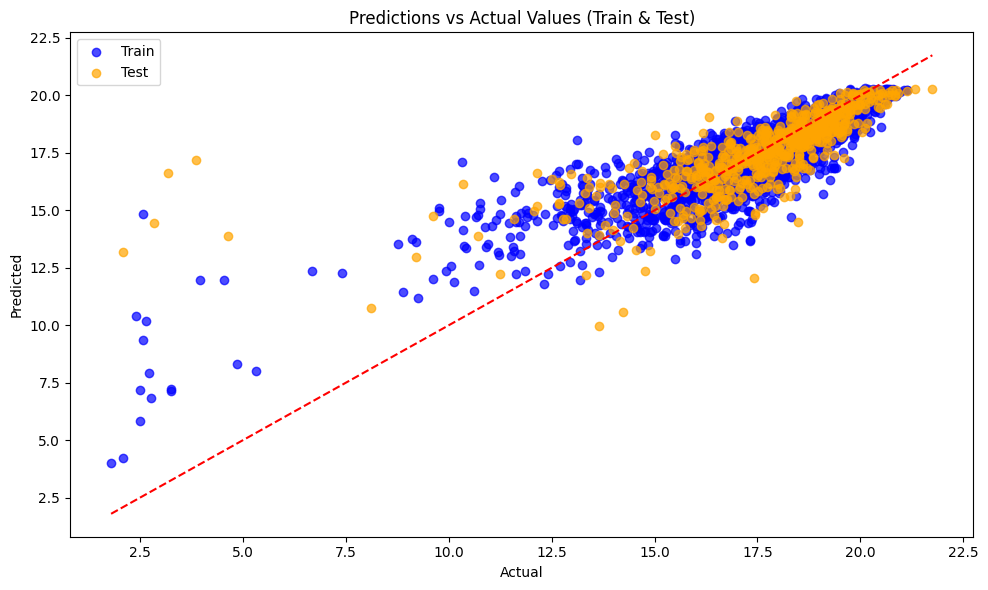

In [17]:
# **5. Train-Test Metrics**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
best_model = [model for name, model in models if name == best_model_name][0]

pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

train_metrics = calculate_metrics(y_train, y_train_pred)
test_metrics = calculate_metrics(y_test, y_test_pred)

metrics_df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MSE": [train_metrics[0], test_metrics[0]],
    "MAE": [train_metrics[1], test_metrics[1]],
    "R²": [train_metrics[2], test_metrics[2]],
})
print(metrics_df)

# **6. Print Examples of Predictions vs Actual Values**
print("\nExamples of Predictions vs Actual Values (Test Set):")
examples_df = pd.DataFrame({
    "Actual": y_test.values[:10],
    "Predicted": y_test_pred[:10]
})
examples_df["Difference"] = examples_df["Actual"] - examples_df["Predicted"]
print(examples_df)

# Plot Predictions vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.7, color="blue", label="Train")
plt.scatter(y_test, y_test_pred, alpha=0.7, color="orange", label="Test")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.title("Predictions vs Actual Values (Train & Test)")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# Convert predictions and actual values back to dollars
actual_dollars = np.expm1(y_test)
predicted_dollars = np.expm1(y_test_pred)

# Examples of Predictions vs Actual Values (in dollars)
examples_df = pd.DataFrame({
    "Actual (Dollars)": actual_dollars.values[:10],
    "Predicted (Dollars)": predicted_dollars[:10]
})
examples_df["Difference (Dollars)"] = examples_df["Actual (Dollars)"] - examples_df["Predicted (Dollars)"]
print("\nExamples of Predictions vs Actual Values (in Dollars):")
print(examples_df)



Examples of Predictions vs Actual Values (in Dollars):
   Actual (Dollars)  Predicted (Dollars)  Difference (Dollars)
0          619042.0         1.949324e+05          4.241096e+05
1        72700000.0         8.299989e+07         -1.029989e+07
2         3200000.0         4.865870e+06         -1.665870e+06
3        38992758.0         3.122349e+07          7.769270e+06
4         2300000.0         4.706090e+06         -2.406090e+06
5        35431113.0         4.456651e+07         -9.135399e+06
6        31554855.0         3.641714e+07         -4.862288e+06
7       222104681.0         2.317797e+08         -9.674973e+06
8       334615000.0         5.035148e+08         -1.688998e+08
9           10000.0         4.315946e+05         -4.215946e+05


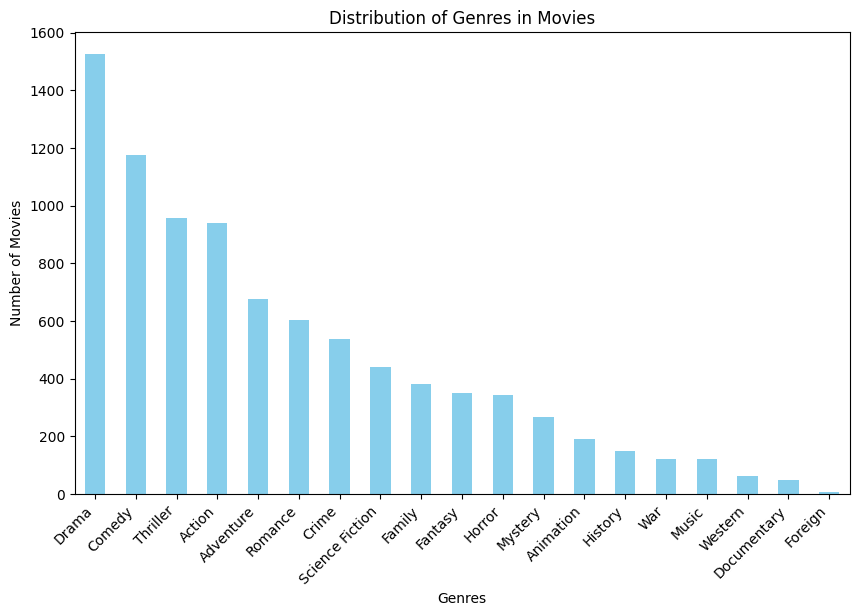

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

all_genres = [genre for genres_list in df['parsed_genres'] for genre in genres_list]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Genres in Movies')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()




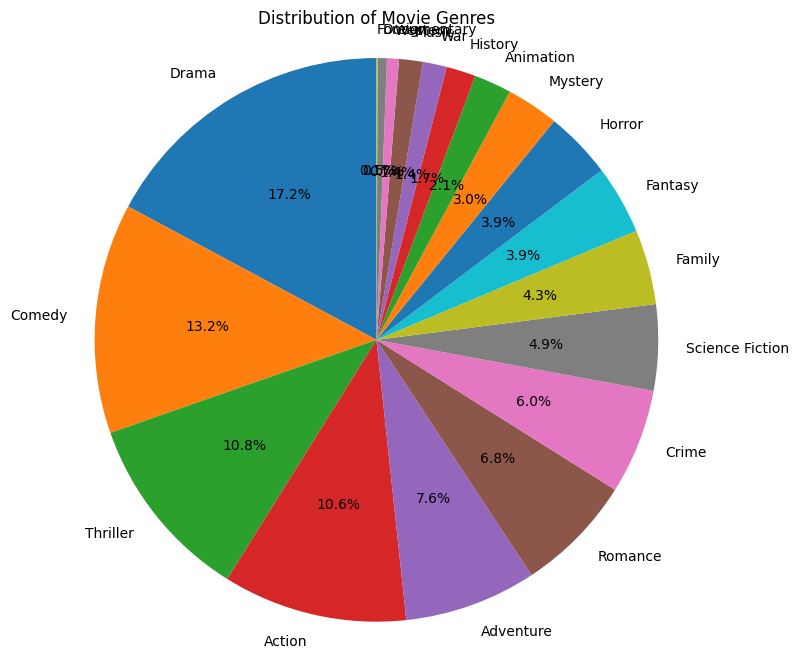

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

all_genres = [genre for genres_list in df['parsed_genres'] for genre in genres_list]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(8, 8))
plt.pie(genre_counts.values, labels=genre_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Movie Genres')
plt.axis('equal')  
plt.show()


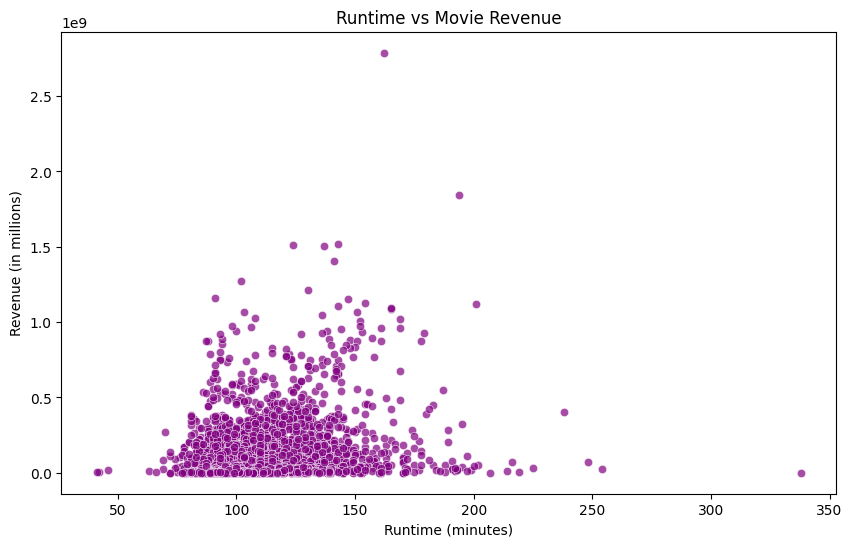

Correlation between Runtime and Revenue: 0.23352618981374199


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns




plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['rt_runtime'], y=df['rt_box_office'], color='purple', alpha=0.7)
plt.title('Runtime vs Movie Revenue')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Revenue (in millions)')
plt.show()


runtime_correlation = df['rt_runtime'].corr(df['rt_box_office'])
print(f"Correlation between Runtime and Revenue: {runtime_correlation}")


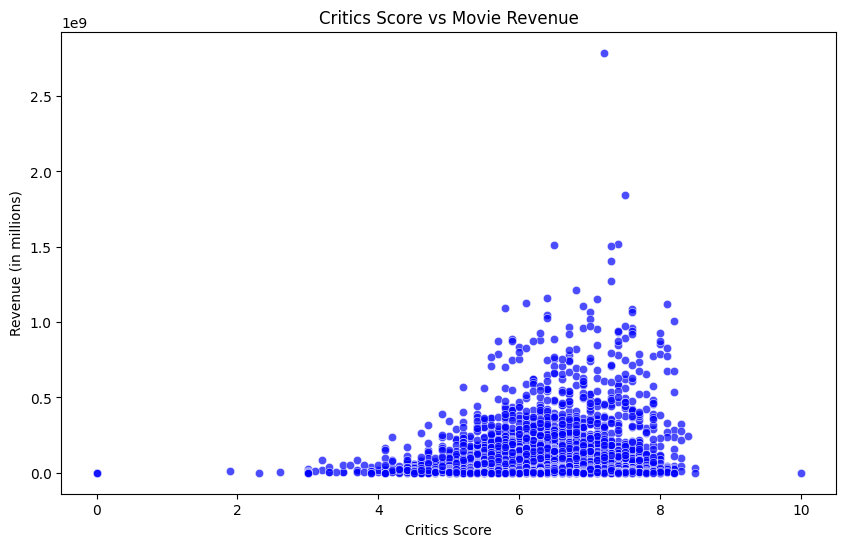

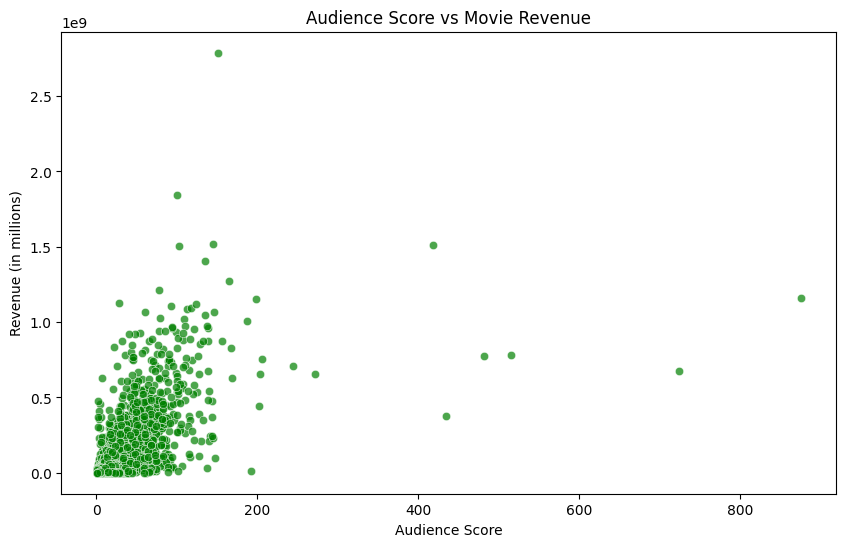

Correlation between Critics Score and Revenue: 0.18023122738411748
Correlation between Audience Score and Revenue: 0.6059394407805616


In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['rt_critics_score'], y=df['rt_box_office'], color='blue', alpha=0.7)
plt.title('Critics Score vs Movie Revenue')
plt.xlabel('Critics Score')
plt.ylabel('Revenue (in millions)')
plt.show()


plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['rt_audience_score'], y=df['rt_box_office'], color='green', alpha=0.7)
plt.title('Audience Score vs Movie Revenue')
plt.xlabel('Audience Score')
plt.ylabel('Revenue (in millions)')
plt.show()


critics_correlation = df['rt_critics_score'].corr(df['rt_box_office'])
print(f"Correlation between Critics Score and Revenue: {critics_correlation}")


audience_correlation = df['rt_audience_score'].corr(df['rt_box_office'])
print(f"Correlation between Audience Score and Revenue: {audience_correlation}")




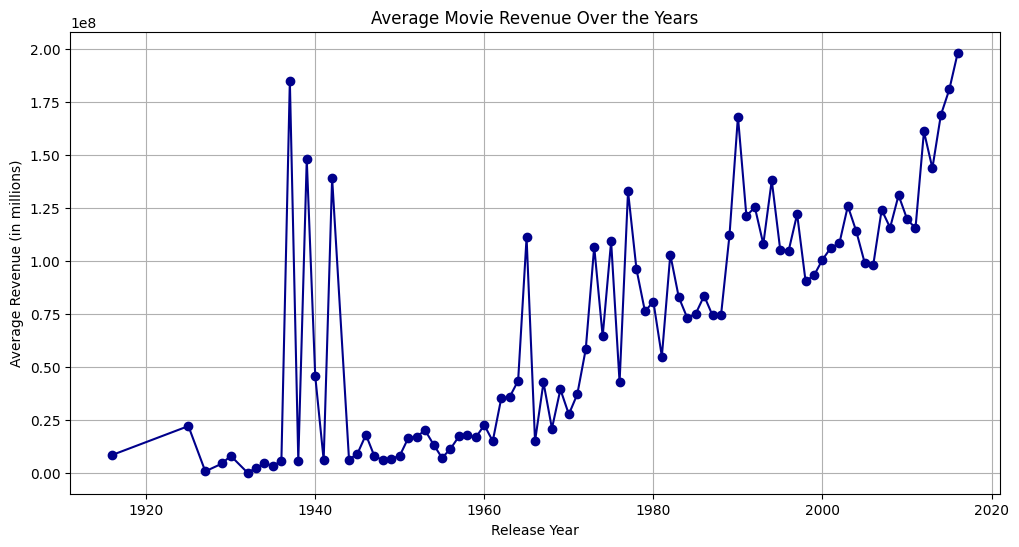

In [20]:

yearly_revenue = df.groupby('release_year')['rt_box_office'].mean()  
plt.figure(figsize=(12, 6))
plt.plot(yearly_revenue.index, yearly_revenue.values, color='darkblue', marker='o')
plt.title('Average Movie Revenue Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Average Revenue (in millions)')
plt.grid(True)
plt.show()


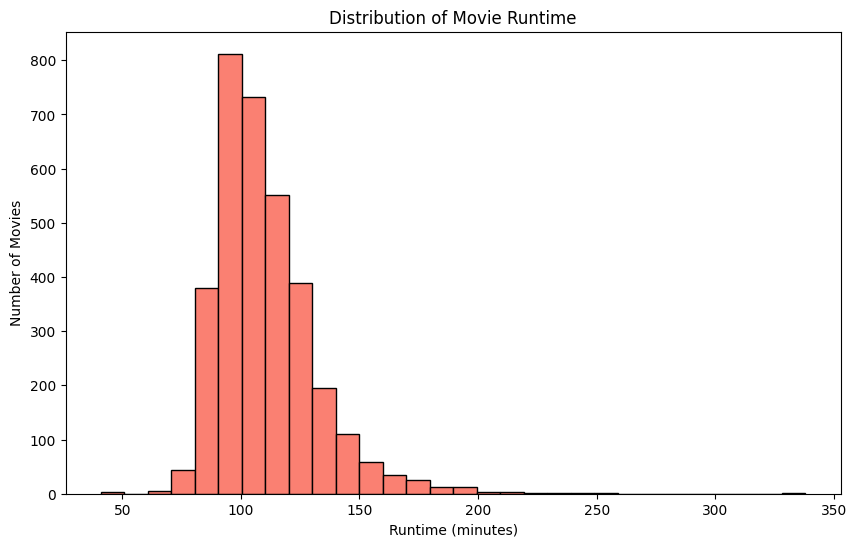

In [21]:

plt.figure(figsize=(10, 6))
plt.hist(df['rt_runtime'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Movie Runtime')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.show()
